In [1]:
import numpy as np
import math
from scipy import spatial
import random
from random import randrange
from scipy.stats import powerlaw
from scipy import stats
import csv
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from apgl.graph import *
from apgl.generator.KroneckerGenerator import KroneckerGenerator
from apgl.io.SimpleGraphWriter import SimpleGraphWriter

Creating the Kornecker Graph using a python Graph Library [APGL](https://pythonhosted.org/apgl/KroneckerGenerator.html). This kronecker graph has 3125 nodes, so it will generate a 3125 by 3125 lattice

In [13]:
## The seed graph is a 5-vertex graph. All of the nodes have a self loop, 
## and apart from that they have the following edges
initialGraph = SparseGraph(VertexList(5, 1))
initialGraph.addEdge(1, 2)
initialGraph.addEdge(2, 3)
initialGraph.addEdge(1, 4)
initialGraph.addEdge(2, 4)
initialGraph.addEdge(1, 3)
initialGraph.addEdge(0, 1)

for i in range(5):
        initialGraph.addEdge(i, i)

        
## Now we are using the seed graph to recrusively generate a kronecker graph that has
## 5^5 = 3125 vertexes
k = 6
generator = KroneckerGenerator(initialGraph, k)
graph = generator.generate()

In [14]:
x = graph.adjacencyMatrix()

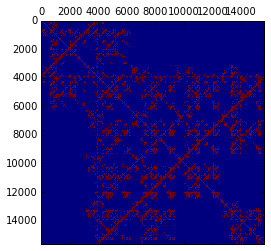

In [15]:
plt.matshow(x)

In [17]:
G = nx.from_numpy_matrix(x)

AttributeError: 'Graph' object has no attribute 'is_connected'

In [20]:
print nx.is_connected(G)
print G.number_of_nodes()

True
15625


Now we are trying the greedy routing from a randomly selected source and a target. This is the algorithm:
- We randomly sample co-ordinates of a source node and a traget node in the 2d lattice. If the value in the adjacency matrix of the randomly sampled nodes are not 1 then we sample the nodes until its value is 1, because the points whose value is 0 in the adjacency matrix are the empty points.

- Then for each value of $\alpha$ we run a greedy routing from each node. As we have already chosen a lattice whose vertices are conncted, we traverse from the source nodes and target nodes. For each timestep we have a current node, who has neighbours on top, bottom, right, left for which the number of steps is 1, and we have the corner neighbors e.g. top-right, top-left, bottom-right and bottom-left, for which the number of step is 2. We only have neigbors if there value in the kronecker adjacency matrix is 1. We also find a shortcut neighbor which is sampled using a power  law distribution using $\alpha$ parameter. If the shortcut neighbor sampled has a value 0 in the adjacency matrix then we sample again until we find a neihbor that has a value of 1 in the adjacency matrix we derive from the kronecker graph.

- We try all the neighbors to take a step. We proceed towards the neighbor that is closest to the target. If we take a step to any of the corner neighbors, we count it as a 2-step movement as we are counting the distance using manhattan distance.

- We count the number of steps it takes to go to the neighbor.

- We run this algortihm 200 times and get the average steps taken from randomly sampled source and target node for each $\alpha$

In [ ]:
edgelist = dict()
dist = dict()

f_out = open("results_kleinberg_final15625.txt","w")

dim = 15625
distances = dict()

output_map = defaultdict(list)




def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    ## Why alpha - 1
    pmf = 1/x**(a-1)
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(1, m+1), pmf))

for net in range(200):
    if net%1==0:
        print net
    si = random.sample(range(dim),1)[0]
    sj = random.sample(range(dim),1)[0]
    while x[si,sj] < 1:
        si = random.sample(range(dim),1)[0]
        sj = random.sample(range(dim),1)[0]
    ti = random.sample(range(dim),1)[0]
    tj = random.sample(range(dim),1)[0]

    while x[ti,tj] < 1:
        ti = random.sample(range(dim),1)[0]
        tj = random.sample(range(dim),1)[0]
    #print "source si-sj", si, sj
    #print "target ti-tj", ti ,tj
    for q1 in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]:
        #print "current q1", q1
        last_nodes = [None]*2
        recur = 0

        cstm = truncated_power_law(q1,23)
        l = 0
        current = str(si)+"-"+str(sj)
        #print "current source",current
        while (current != str(ti)+"-"+str(tj) and l <= dim*2):
            d_min = 1000
            edgelist[current] = []
            ii = int(current.split("-")[0])
            ij = int(current.split("-")[1])
            if ii < dim-1:
                if x[ii+1,ij] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij),1])
                if ij < dim -1:
                    if x[ii+1,ij+1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij+1),2])
                if ij > 0:
                    if x[ii+1,ij-1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij-1),2])
            if ij < dim-1:
                if x[ii,ij+1] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii)+"-"+str(ij+1),1])
                if ii > 0:
                    if x[ii-1,ij+1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij+1),2])
            if ii > 0:
                if x[ii-1,ij] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij),1])
                if ij > 0:
                    if x[ii-1,ij-1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij-1),2])
            if ij > 0:
                if x[ii,ij-1] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii)+"-"+str(ij-1),1])

            #print "edgelist without shortcut",edgelist
            no_shortcuts = 1
            ## What is d_max ??
            d_max = 1
            shortcut_found = False
            while not shortcut_found:
                for shortcuts in range(no_shortcuts):
                    r_sample = cstm.rvs()
                    #print "r_sample", r_sample
                    if (math.floor(r_sample*d_max) > 1):
                        k = random.sample(range(int(math.floor(r_sample*d_max))),1)[0]
                        #print "k", k
                        k1 = k
                        k2 = math.floor(r_sample*d_max) - k1
                        #print "k1, k2", k1, k2
                        ni = []
                        nj = []
                    if (ii + k1 <= dim-1) and (ij + k2 <= dim-1):
                        if x[ii + k1,ij + k2] > 0:
                            ni.append(ii + k1)
                            nj.append(ij + k2)
                    if (ii + k1 <= dim-1) and (ij - k2 >= 0):
                        if x[ii + k1,ij - k2] > 0:
                            ni.append(ii + k1)
                            nj.append(ij - k2)
                    if (ii - k1 >= 0) and (ij + k2 <= dim-1):
                        if x[ii - k1,ij + k2] > 0:
                            ni.append(ii - k1)
                            nj.append(ij + k2)
                    if (ii - k1 >= 0) and (ij - k2 >= 0):
                        if x[ii - k1,ij - k2] > 0:
                            ni.append(ii - k1)
                            nj.append(ij - k2)
                    #print "ni-nj" ,ni , nj
                    if ni != []:
                        k = random.sample(range(len(ni)),1)[0]
                        edgelist[current].append([str(int(ni[k]))+"-"+str(int(nj[k])),1])
                        shortcut_found = True
            #print "with shortcut", edgelist
            for p, footstep in edgelist[current]:
                pi = p.split("-")[0]
                pj = p.split("-")[1]
                #tempi = 0
                #tempj = 0
                temp_footstep = 1
                if spatial.distance.cityblock(np.array([ti,tj]),np.array([int(pi),int(pj)])) < d_min:
                    d_min = spatial.distance.cityblock(np.array([ti,tj]),np.array([int(pi),int(pj)]))
                    tempi = pi
                    tempj = pj
                    temp_footstep = footstep
            current = str(tempi).rstrip()+"-"+str(tempj).rstrip()


            #print "next node is", current, "temp_footstep is", temp_footstep
            l = l + temp_footstep
            #print "current l", l
        #print "final l", l
        print >> f_out, q1, l, si, sj, ti, tj
        output_map[q1].append(l)

f_out.close()

0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:94: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:98: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:102: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:106: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The fractal dimension for the embedding lattice is, fd = 1.73009931755022. Now we are plotting the log of average steps taken vs the $\alpha$ values.

In [ ]:
output_for_plot = {n: sum(output_map[n])/float(len(output_map[n])) for n in output_map.keys()}
plt.figure(figsize=(10,10))
plt.plot(output_for_plot.keys(), np.log(output_for_plot.values()), 'ro')
plt.title("")
plt.ylabel("ln T for the greedy algorithm")
plt.xlabel(r"Clustering Exponent $\alpha$")
plt.xticks(np.arange(0,2.6,0.2))
plt.show()